In [1]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import random
import pingouin
import os

#plots.py
# . . .
def plot_lines(df, linewidth = 1, figsize = (40,20),
               secondary_y = None, legend=True,
               h_zero = True, pp = None, 
               save_fig = False):
    
    fig, ax = plt.subplots(figsize = figsize)    
    # If no secondary_y (axis), plot all variables at once
    df.dropna().plot.line(linewidth = linewidth, ax = ax, secondary_y=secondary_y, legend = legend)
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    # transform y-axis values from sci notation to integers
    vals = ax.get_yticks()
    ax.set_yticklabels([round(x,2) for x in vals]) 
    if h_zero: ax.axhline(0, ls="--", color = "k")
    
    # format image filename 
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")  
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + filename[:50] + " line.png", 
                bbox_inches = "tight")
    #[:50] + " line.png"
    # save image if PdfPages object was passed
    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_scatter(data, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    # Create plot for every unique pair of variables
    df = data.copy()
    for var1 in df:
        for var2 in df:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, 
                                c = "Year", cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                    plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " scatter.png",
                            bbox_inches = "tight")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def corr_matrix_heatmap(df, save_fig = False, pp = None):  
    #Create a figure to visualize a corr matrix  
    fig, ax = plt.subplots(figsize=(20,20))  
    # use ax.imshow() to create a heatmap of correlation values  
    # seismic mapping shows negative values as blue and positive values as red  
    im = ax.imshow(df, norm = plt.cm.colors.Normalize(-1,1), cmap = "seismic")  
    # create a list of labels, stacking each word in a label by replacing " "  
    # with "\n"  
    labels = df.keys()  
    num_vars = len(labels)  
    tick_labels = [lab.replace(" ", "\n") for lab in labels]  
    # adjust font size according to the number of variables visualized  
    tick_font_size = 120 / num_vars  
    val_font_size = 200 / num_vars  
    plt.rcParams.update({'font.size': tick_font_size}) 
    # prepare space for label of each column  
    x_ticks = np.arange(num_vars)  
    # select labels and rotate them 90 degrees so that they are vertical  
    plt.xticks(x_ticks, tick_labels, fontsize = tick_font_size, rotation = 90)  
    # prepare space for label of each row  
    y_ticks = np.arange(len(labels))  
    # select labels  
    plt.yticks(y_ticks, tick_labels, fontsize = tick_font_size)  
    # show values in each tile of the heatmap  
    for i in range(len(labels)):  
        for j in range(len(labels)):  
            text = ax.text(i, j, str(round(df.values[i][j],2)),  
                           fontsize= val_font_size, ha="center",   
                           va="center", color = "w")  
    #Create title with Times New Roman Font  
    title_font = {"fontname":"Times New Roman"}  
    plt.title("Correlation", fontsize = 50, **title_font)  
    #Call scale to show value of colors 
    cbar = fig.colorbar(im)
    plt.show()
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " corrMatrix.png",
            bbox_inches = "tight")

        if pp != None: pp.savefig(fig, bbox_inches="tight")
    plt.close()

def plot_stacked_lines(df, plot_vars, linewidth = 1, 
                       figsize = (40, 20),
                       pp = None, total_var = False,
                      title = False):
    fig, ax = plt.subplots(figsize = figsize)
    # df.plot.area() created a stacked plot
    df[plot_vars].plot.area(stacked = True, linewidth = linewidth,
                            ax = ax)
    if total_var != False:
        df[total_var].plot.line(linewidth = linewidth, ax = ax,
                                c = "k",label = total_var, 
                                ls = "--")
    # place legend in top left corner of plot
    # format legend so that there are two columns of names
    ax.legend(loc = 2, ncol = 2)
    if title != False:
        plt.title(title)
        
def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()
            
    return df

In [20]:

data_dict = {"PPI: All Comodities": "PPIACO",
             "PPI: Lumber and Wood Products":"WPU081",
            "PPI: Copper and Copper Products":"WPUSI019011",
            "PPI: Gas and Oil Extraction":"PCU21112111",
            "Expected Inflation: 5 Year Breakeven Rate":"T5YIE",
            "CPI: Urban Consumption":"CPIAUCSL",
             "$CPI_{Core}$":"PCEPILFE",
            "Industrial Production Index":"INDPRO",
            "$\pi_{e_{5Y}}$":"T5YIE",
             "$\pi_{e_{10Y}}$":"T10YIE",
            "M2":"WM2NS",
            "Personal Savings Rate":"PSAVERT"}
freq = "M"
start = datetime.datetime(1990, 1, 1)
# end = datetime.datetime(1985, 12, 31)
end =datetime.datetime.today()

df = gather_data(data_dict, start, 
          end = end, freq = freq)

In [21]:
keys = df.keys()
for key in keys:
#     if "PPI" in key or "CPI" in key or "M2" in key:
    df[key + " Annual % Change"] = df[key].pct_change(12) * 100
df.rename(columns = {"$CPI_{Core}$ Annual % Change":"$\pi_{Core}$",
                    "PPI: All Comodities Annual % Change":"$\pi_{PPI}$"}, inplace = True)

In [22]:
df

,PPI: All Comodities,PPI: Lumber and Wood Products,PPI: Copper and Copper Products,PPI: Gas and Oil Extraction,Expected Inflation: 5 Year Breakeven Rate,CPI: Urban Consumption,$CPI_{Core}$,Industrial Production Index,$\pi_{e_{5Y}}$,$\pi_{e_{10Y}}$,...,PPI: Copper and Copper Products Annual % Change,PPI: Gas and Oil Extraction Annual % Change,Expected Inflation: 5 Year Breakeven Rate Annual % Change,CPI: Urban Consumption Annual % Change,$\pi_{Core}$,Industrial Production Index Annual % Change,$\pi_{e_{5Y}}$ Annual % Change,$\pi_{e_{10Y}}$ Annual % Change,M2 Annual % Change,Personal Savings Rate Annual % Change
DATE,,,,,,,,,,,,,,,,,,,,,
1990-01-31,114.9,124.5,159.0,82.0,NaN,127.500,63.706,61.9021,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-02-28,114.4,125.8,153.5,82.3,NaN,128.000,64.016,62.4640,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-03-31,114.2,127.4,165.4,77.9,NaN,128.600,64.323,62.7645,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-30,114.1,129.3,172.0,73.1,NaN,128.900,64.515,62.6499,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-31,114.6,128.0,170.2,73.8,NaN,129.100,64.712,62.8126,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30,217.9,390.3,504.7,153.0,2.529545,266.832,116.100,99.2301,2.529545,2.349545,...,49.275362,180.219780,233.461736,4.153135,3.082715,17.847956,233.461736,112.949739,18.820131,-63.313609
2021-05-31,224.4,452.1,563.0,167.4,2.649500,268.551,116.766,99.8504,2.649500,2.468000,...,63.567693,135.112360,246.339869,4.926507,3.457258,16.316921,246.339869,121.246078,14.572262,-59.677419
2021-06-30,228.5,444.5,560.8,179.2,2.464545,270.981,117.327,100.3398,2.464545,2.342727,...,55.864369,104.800000,143.030031,5.324508,3.586280,10.067331,143.030031,84.005712,12.904184,-53.367876


In [23]:
# set default fontsize for text in plot
plt.rcParams.update({'font.size': 42})
plt.rcParams['axes.ymargin'] = .05
plt.rcParams['axes.xmargin'] = .05
plot_keys = ["PPI: Lumber and Wood Products Annual % Change",
             "PPI: Copper and Copper Products Annual % Change",
             "PPI: Gas and Oil Extraction Annual % Change"]
plot_df = df[plot_keys]


<ipython-input-1-8ba7c77b1e5b>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


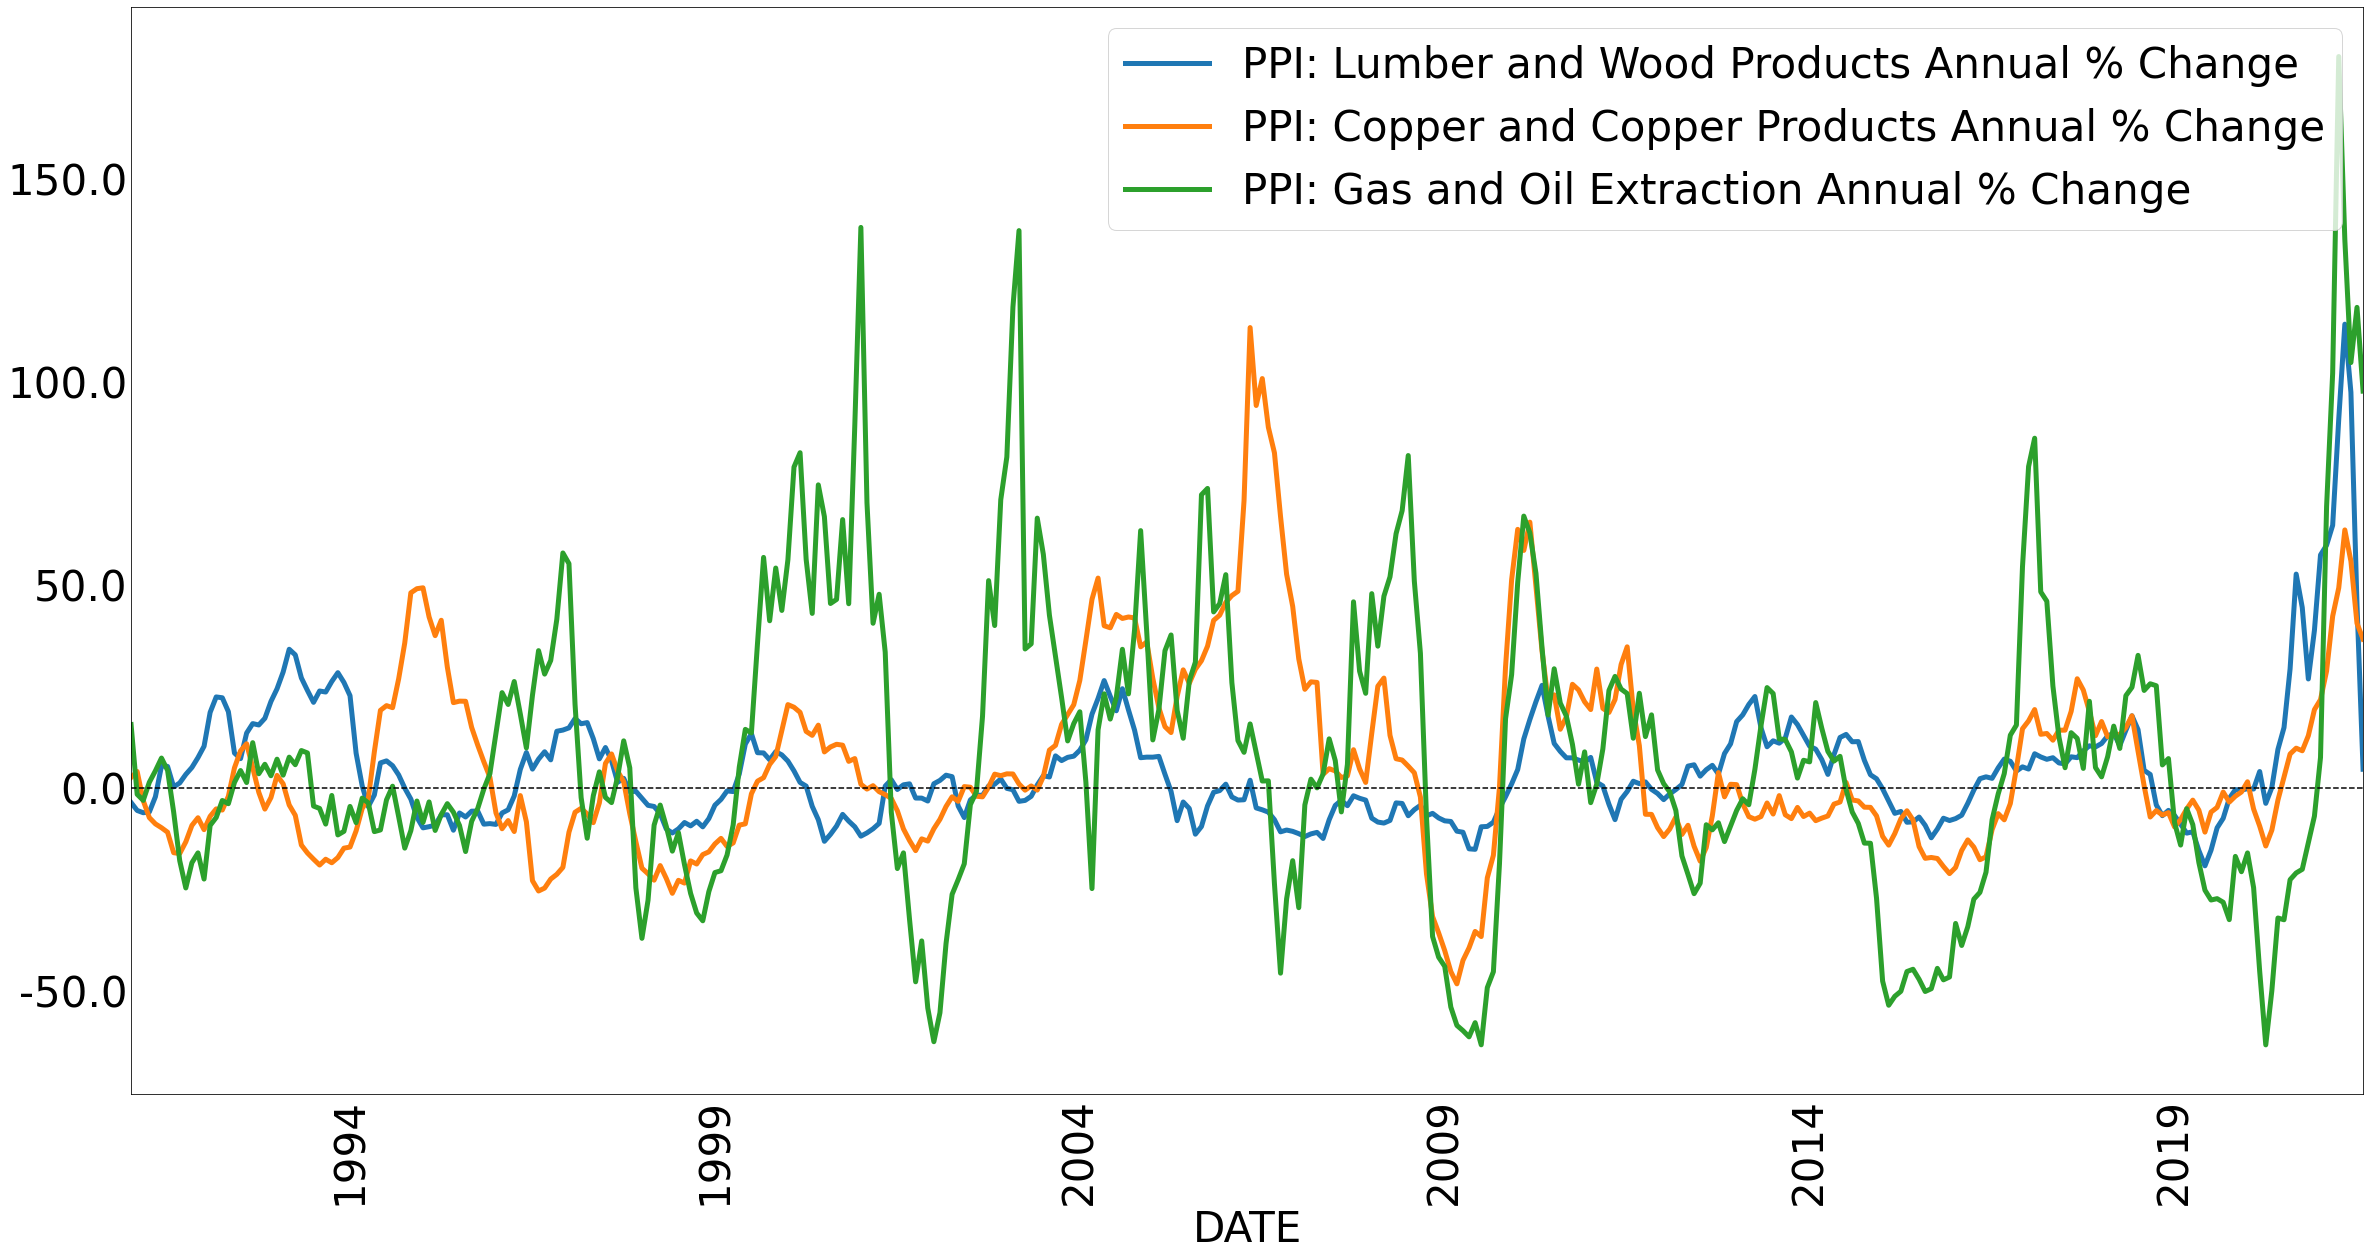

In [24]:
plot_lines(plot_df, linewidth = 5)
plot_df.to_csv("PPIData.csv")

<ipython-input-1-8ba7c77b1e5b>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


,$\pi_{PPI}$,$\pi_{Core}$,$\pi_{e_{5Y}}$
DATE,,,
1990-01-31,NaN,NaN,NaN
1990-02-28,NaN,NaN,NaN
1990-03-31,NaN,NaN,NaN
1990-04-30,NaN,NaN,NaN
1990-05-31,NaN,NaN,NaN
...,...,...,...
2021-04-30,17.466307,3.082715,2.529545
2021-05-31,18.981972,3.457258,2.649500
2021-06-30,19.508368,3.586280,2.464545


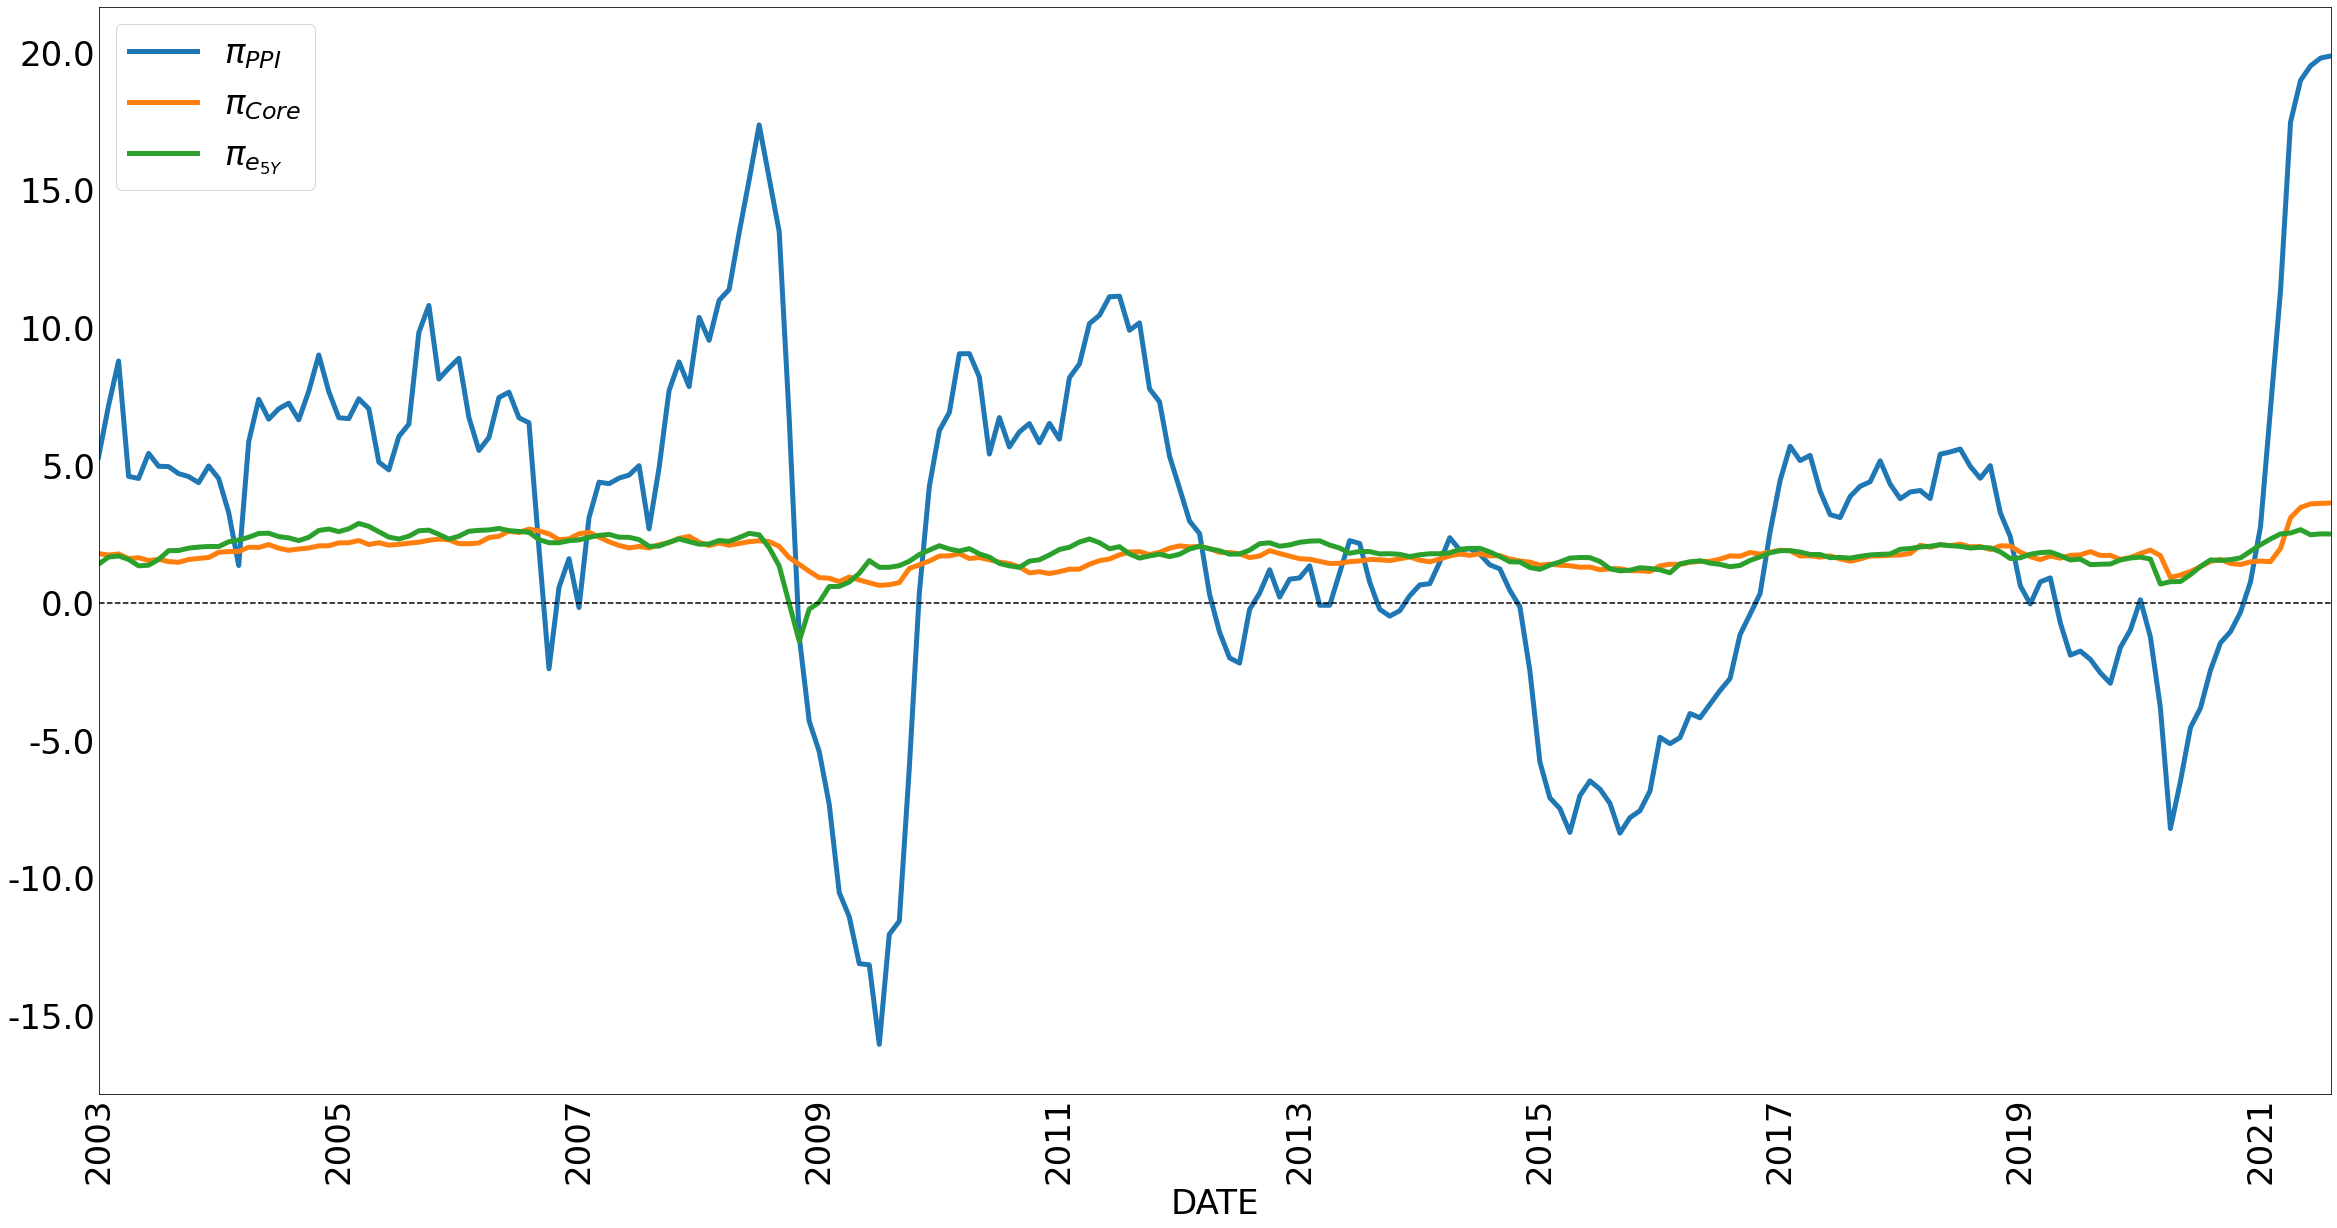

In [25]:
plt.rcParams.update({'font.size': 34})
plot_keys = ["$\pi_{PPI}$", 
             "$\pi_{Core}$",
             "$\pi_{e_{5Y}}$"]
plot_df = df[plot_keys]
plot_lines(plot_df, linewidth = 5)
plot_df#.to_csv("inflationData.csv")

In [26]:
df["$\pi_{Core} - \pi_{e_{5Y}}$"] = df["$\pi_{Core}$"].sub(df["$\pi_{e_{5Y}}$"])
df["$\pi_{Core} - \pi_{e_{10Y}}$"] = df["$\pi_{Core}$"].sub(df["$\pi_{e_{10Y}}$"])

<ipython-input-27-9c08bfe8dbb6>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val)) + "%" for val in ax.get_yticks()], fontsize = 26)


Text(505, -1, '$\\pi_{Core} - \\pi_{e_{5Y}}$')

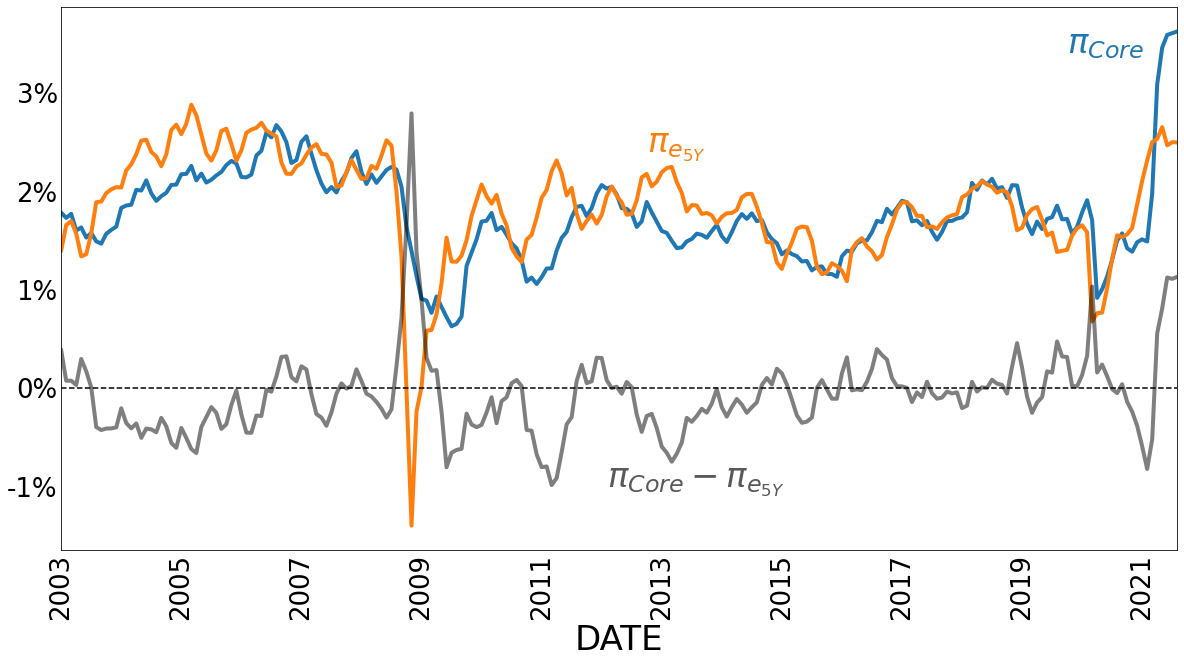

In [27]:
 plot_keys = ["$\pi_{Core}$",
             "$\pi_{e_{5Y}}$",
            "$\pi_{Core} - \pi_{e_{5Y}}$"]
plot_df = df[plot_keys].dropna()#.rolling(12).mean()
fig,ax = plt.subplots(figsize=(20,10))
plot_df[plot_keys[:2]].plot(ax = ax, linewidth = 4, legend = False)
plot_df[plot_keys[2]].plot(ax = ax, linewidth = 4, color = "k", ls="-", alpha = .5)
ax.axhline(0, ls = "--", color = "k")
ax.set_yticklabels([str(int(val)) + "%" for val in ax.get_yticks()], fontsize = 26)
plt.xticks(rotation=90, fontsize =26)
ax.tick_params('both', length=0, which='both')
ax.text(597,3.4 ,  plot_keys[0], color = "C0", alpha = 1)
ax.text(513,2.4,  plot_keys[1], color = "C1", alpha = 1)
ax.text(505,-1 , plot_keys[2], color = "k", alpha = .65)

# plot_df#.to_csv("inflationData.csv")

<ipython-input-225-8ba7c77b1e5b>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(x,2) for x in vals])


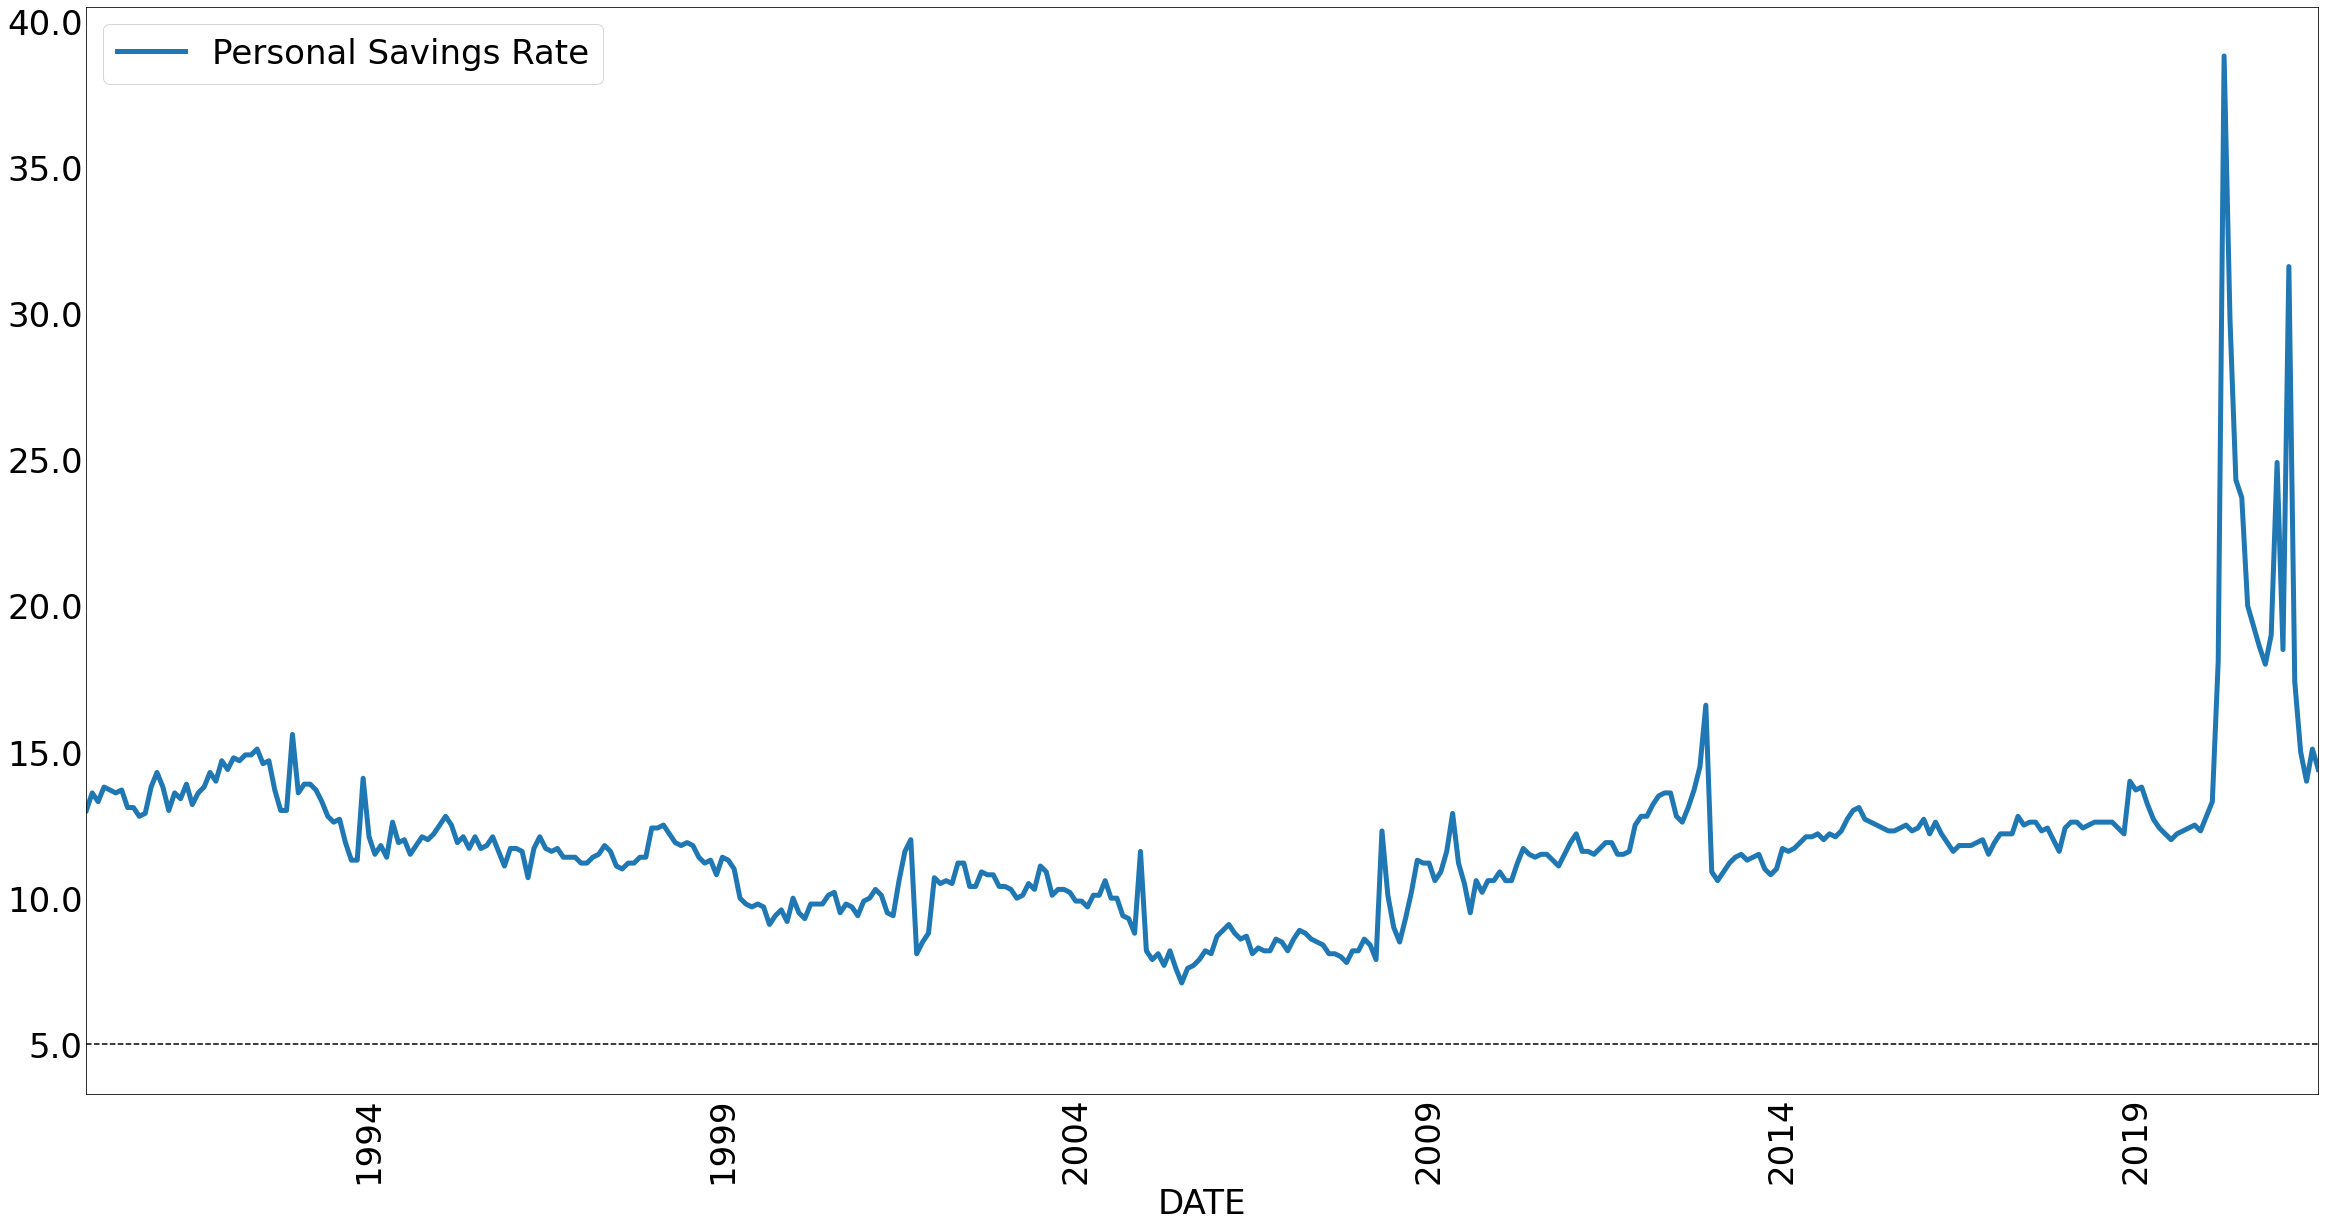

In [515]:
plot_keys = ["Personal Savings Rate"]
plot_df = df[plot_keys]#.rolling(12).mean()
plot_lines(plot_df, linewidth = 5)
# plot_df#.to_csv("inflationData.csv")

Text(0.5, 1.0, '$\\pi_{Core}$ - $\\pi_{e_{5Y}}$')

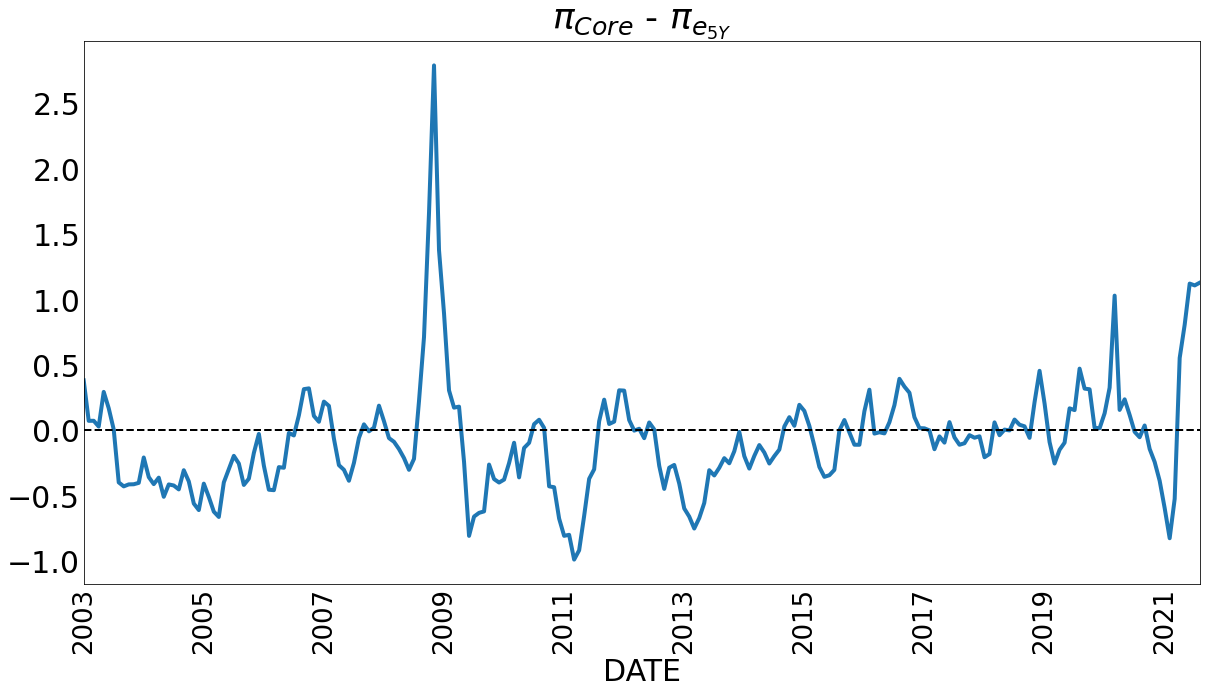

In [516]:
plt.rcParams.update({'font.size': 30})
fig,ax = plt.subplots(figsize=(20,10))
df["$\pi_{Core} - \pi_{e_{5Y}}$"].dropna().plot.line(linewidth = 4, legend = False)
ax.axhline(0,ls="--", linewidth = 2, color = "k")
plt.xticks(rotation=90, fontsize =26)
ax.tick_params('both', length=0, which='both')
plt.title("$\pi_{Core}$ - $\pi_{e_{5Y}}$")

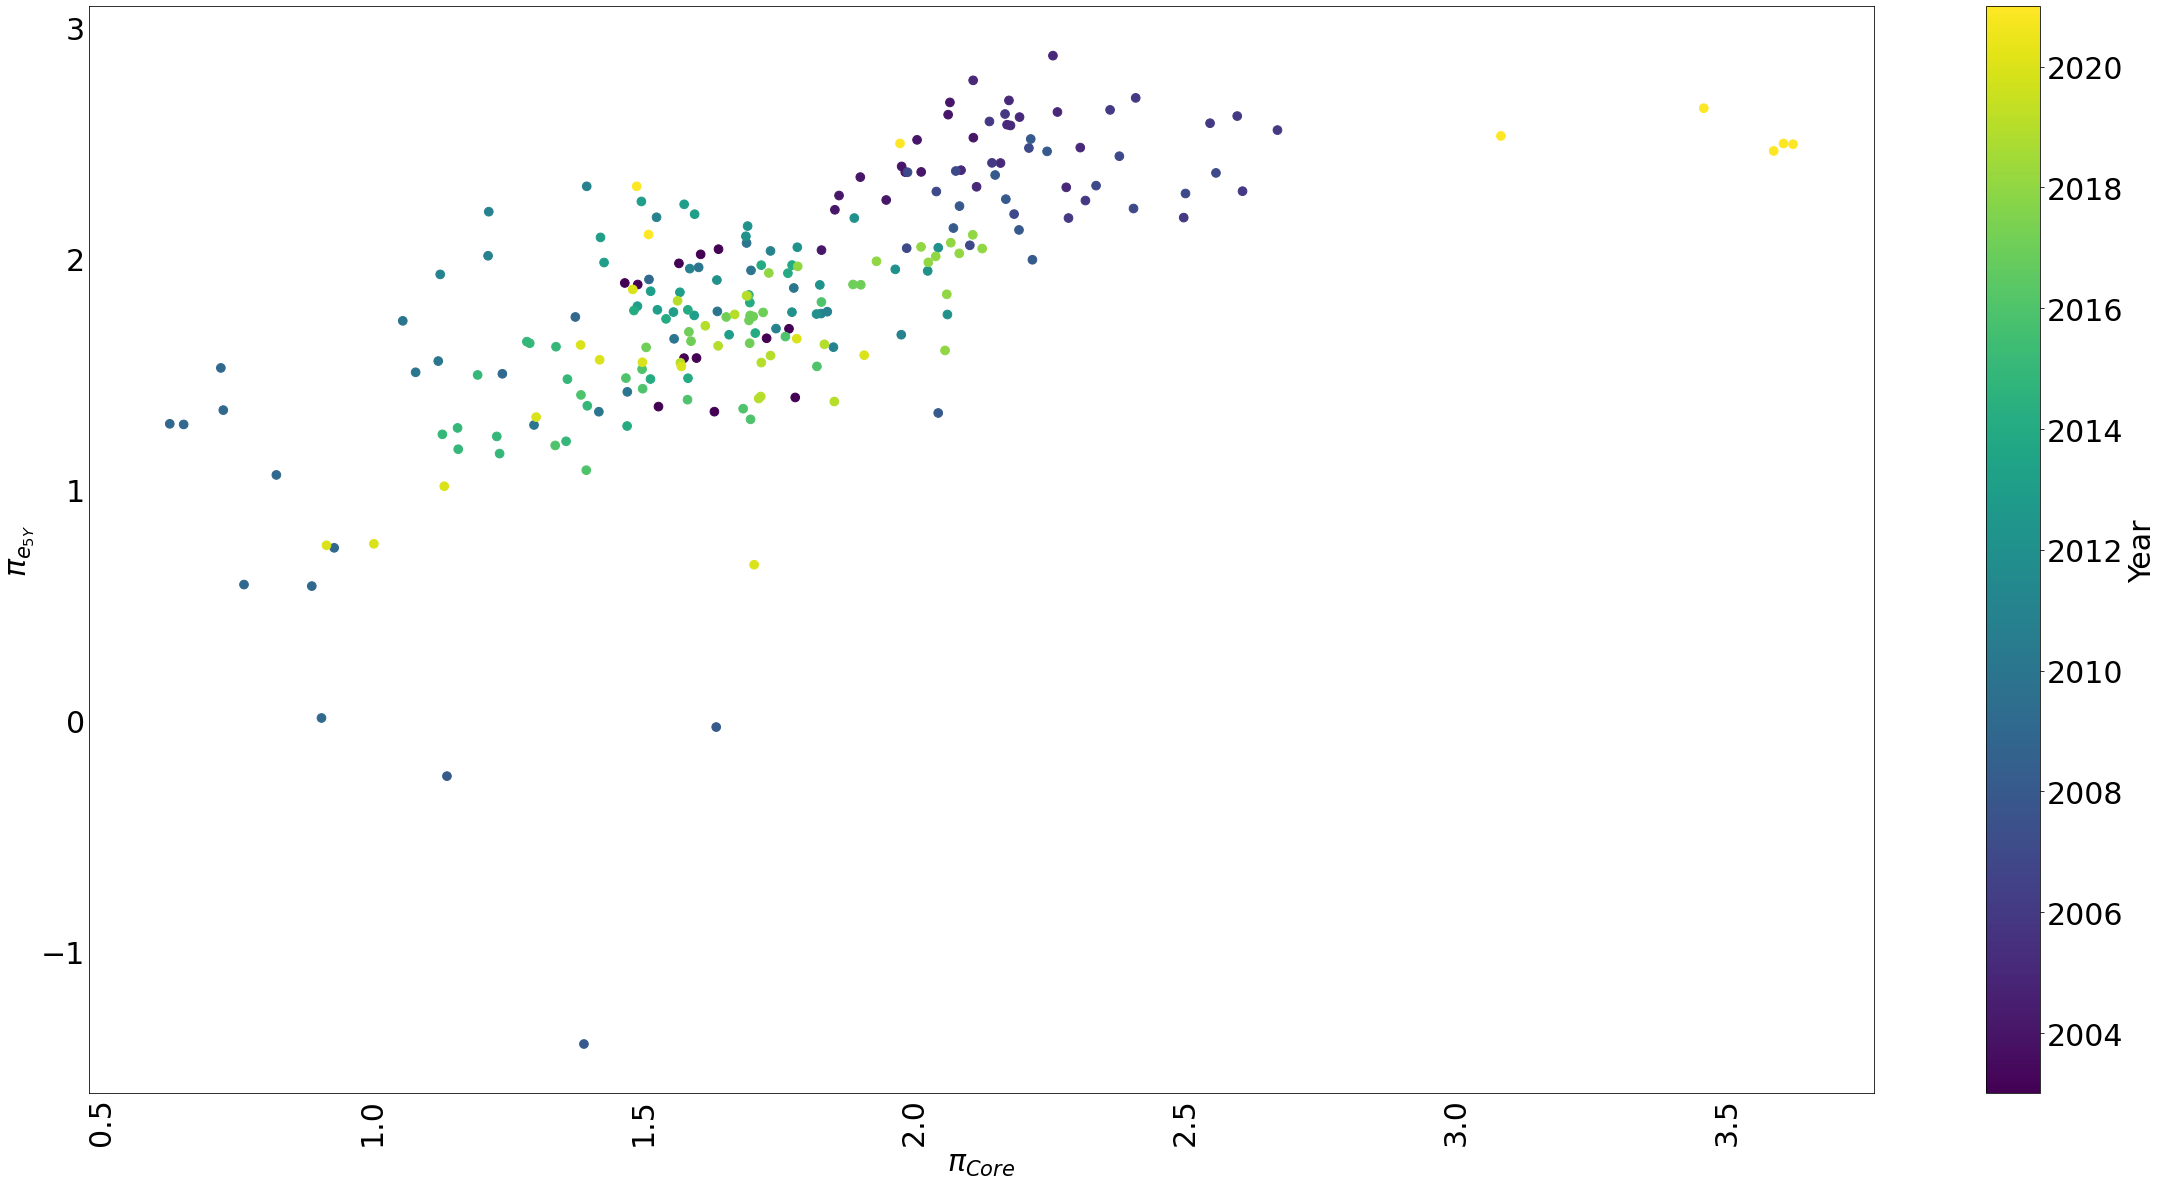

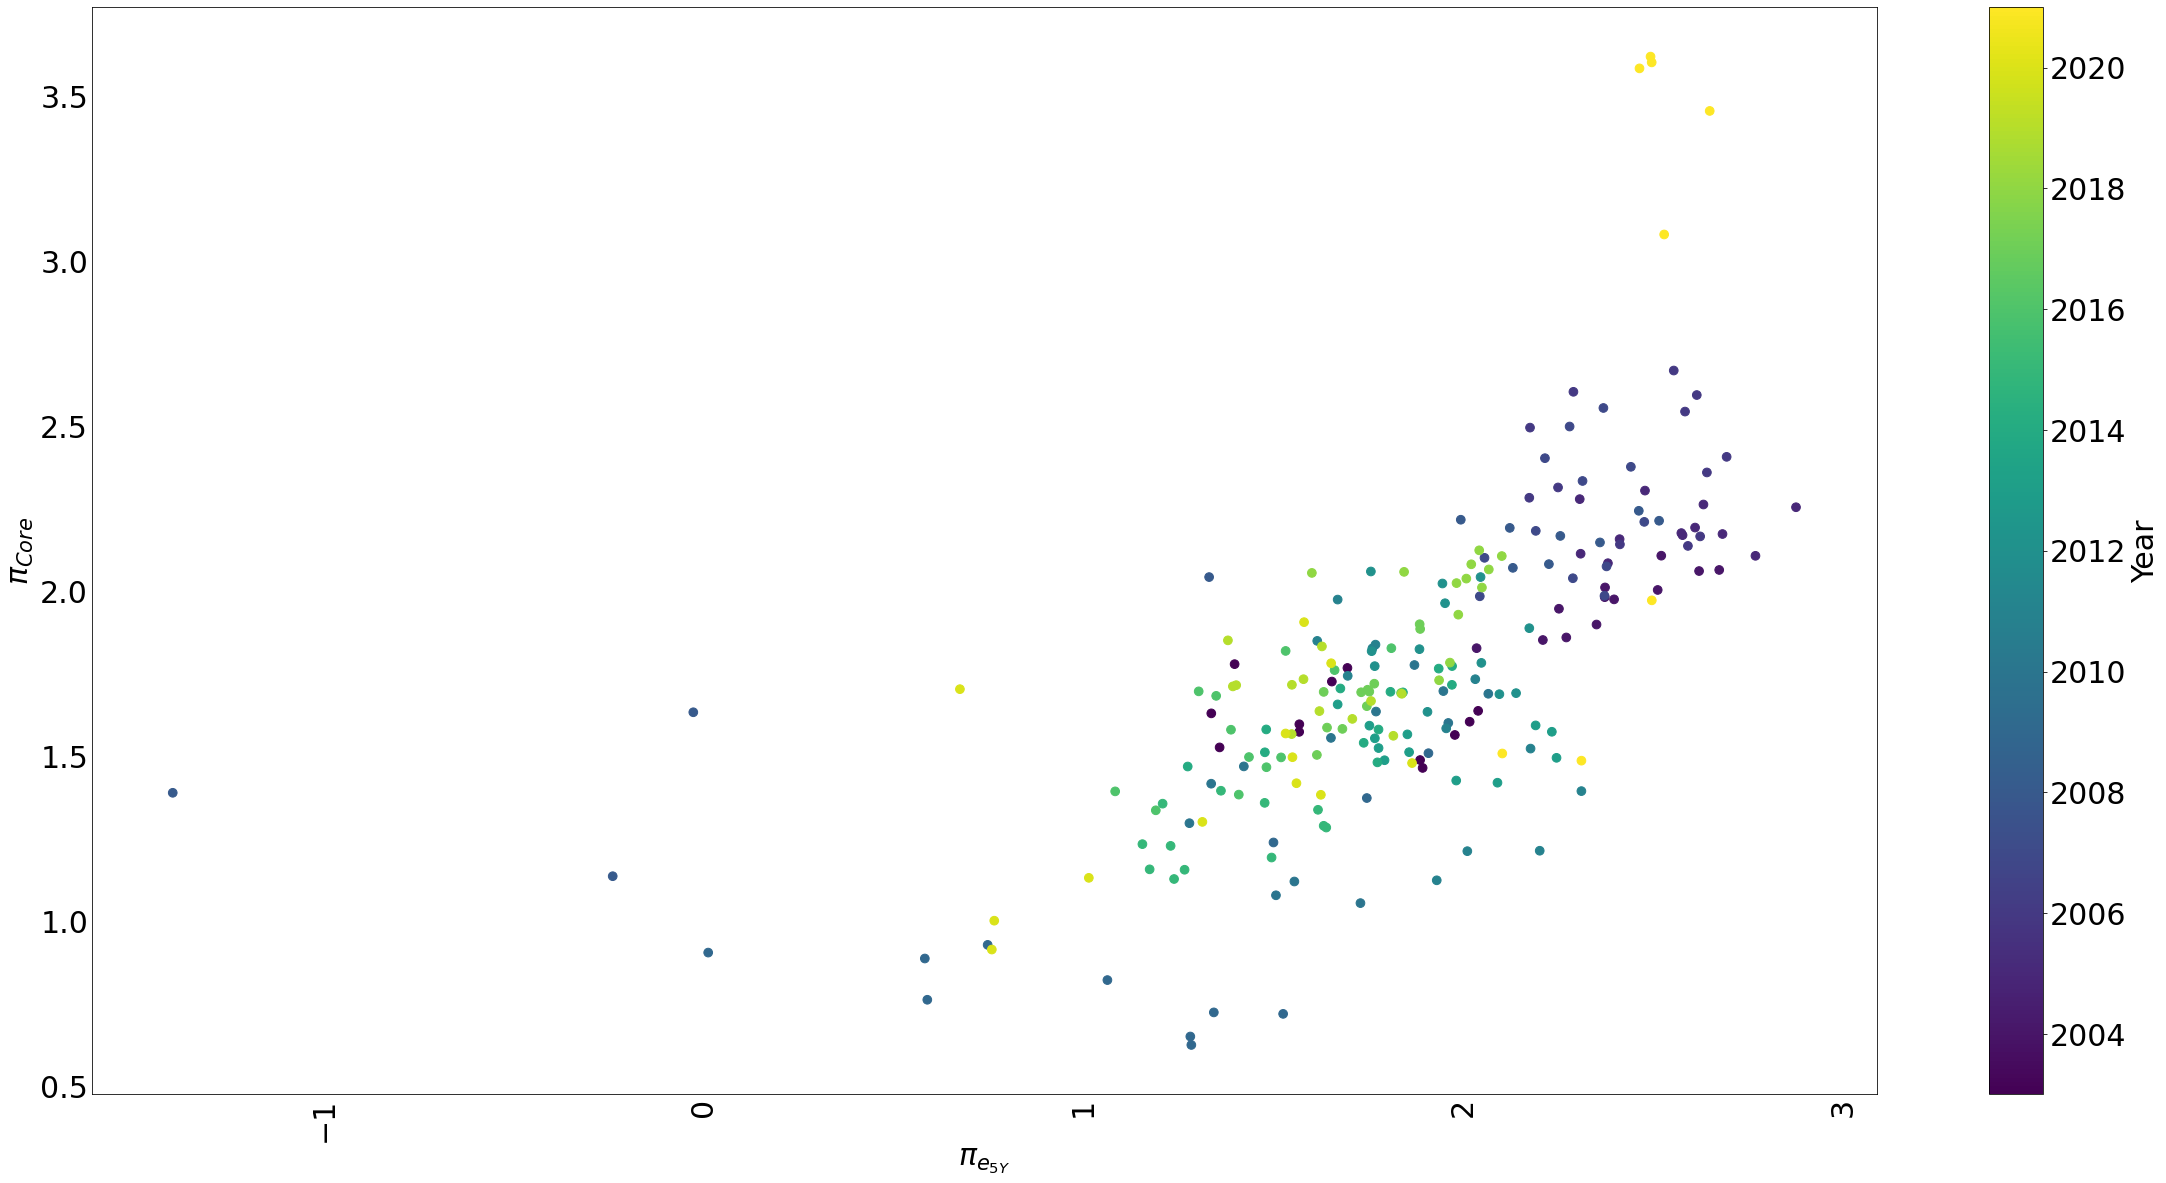

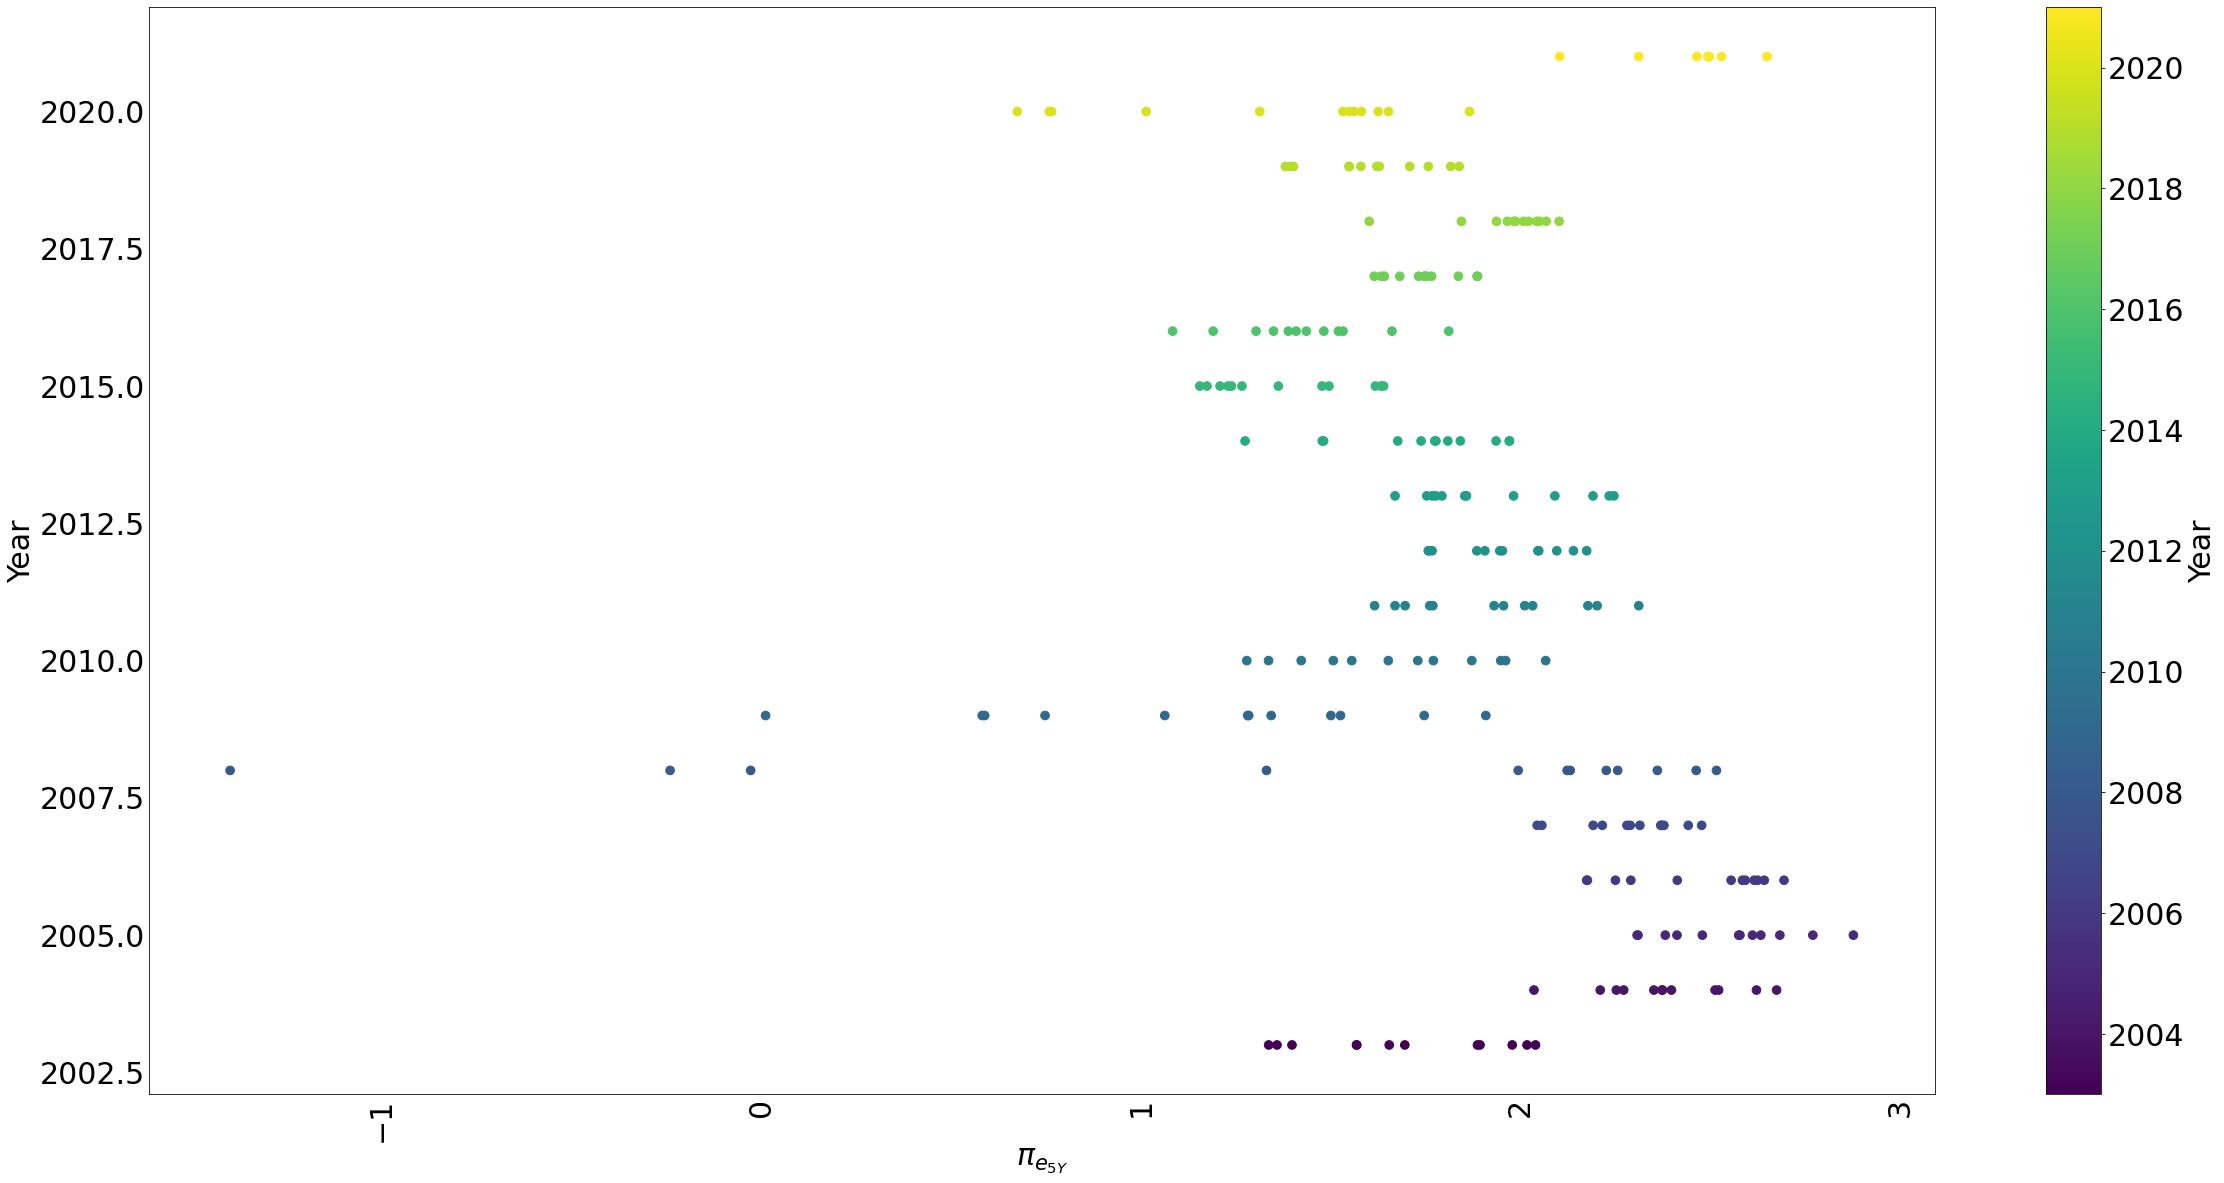

In [517]:
plot_keys=["$\pi_{Core}$",
           "$\pi_{e_{5Y}}$"]
plot_df = df[plot_keys]
plot_scatter(plot_df)

<ipython-input-536-a6490cd01101>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val)) + "%" for val in ax.get_yticks()])
<ipython-input-536-a6490cd01101>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([str(int(val)) + "%" for val in ax2.get_yticks()])


Text(0, 0.5, 'Annual Change')

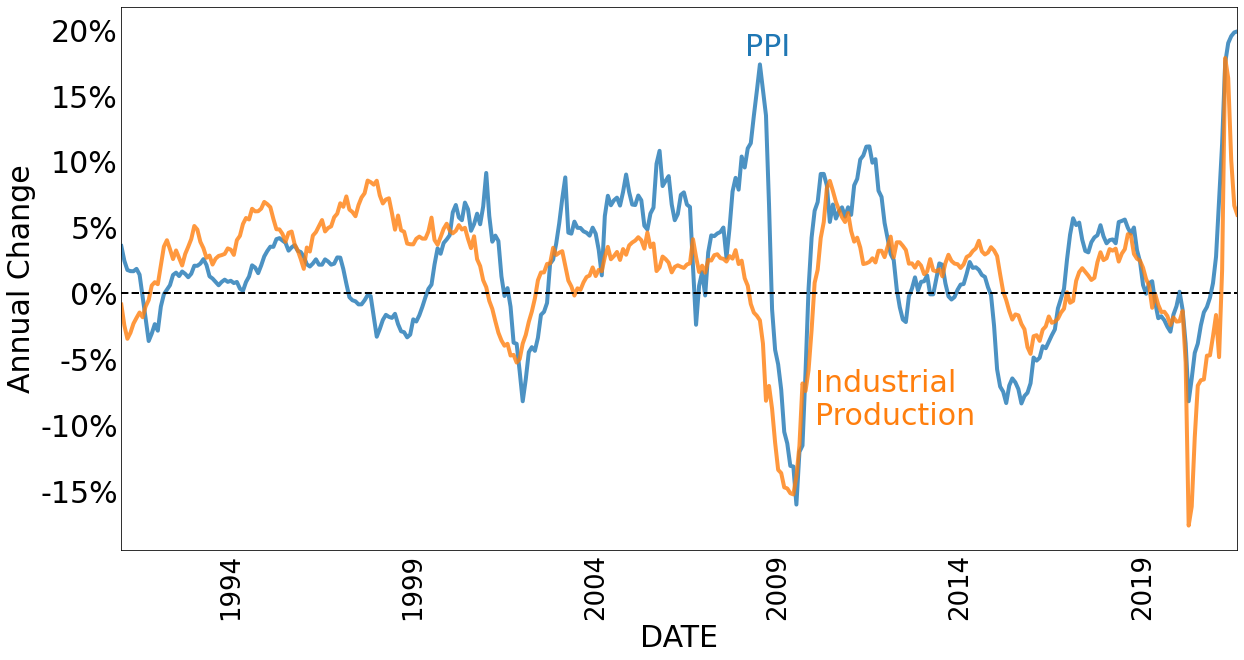

In [536]:
plot_keys = ["$\pi_{PPI}$",
             "Industrial Production Index Annual % Change"]
plot_df = df[plot_keys]
fig,ax = plt.subplots(figsize=(20,10))

plot_df[plot_keys].dropna().plot.line(linewidth = 4, 
                           legend = False,
                          ax = ax,
                          alpha = .8)
# ax2 =ax.twinx()
# plot_df[plot_keys[1]].dropna().plot.line(linewidth = 4, 
#                            legend = False,
#                           ax = ax2,
#                           alpha = .8, color = "C2")

ax.set_yticklabels([str(int(val)) + "%" for val in ax.get_yticks()])
ax2.set_yticklabels([str(int(val)) + "%" for val in ax2.get_yticks()])

ax.axhline(0,ls="--", linewidth = 2, color = "k")
ax.text(457,18,"PPI", color = "C0")
ax.text(480,-10,"Industrial Production".replace(" ","\n"), color = "C1")
# ax.text(593,25,"M2", color = "C2")
plt.xticks(rotation=90, fontsize =26)
ax.tick_params('both', length=0, which='both')
ax.set_ylabel("Annual Change")

<ipython-input-575-3324437f5a63>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(val) + "%" for val in ax.get_yticks()], color = "C0")
<ipython-input-575-3324437f5a63>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([str(val) + "%" for val in ax2.get_yticks()], color = "C2")


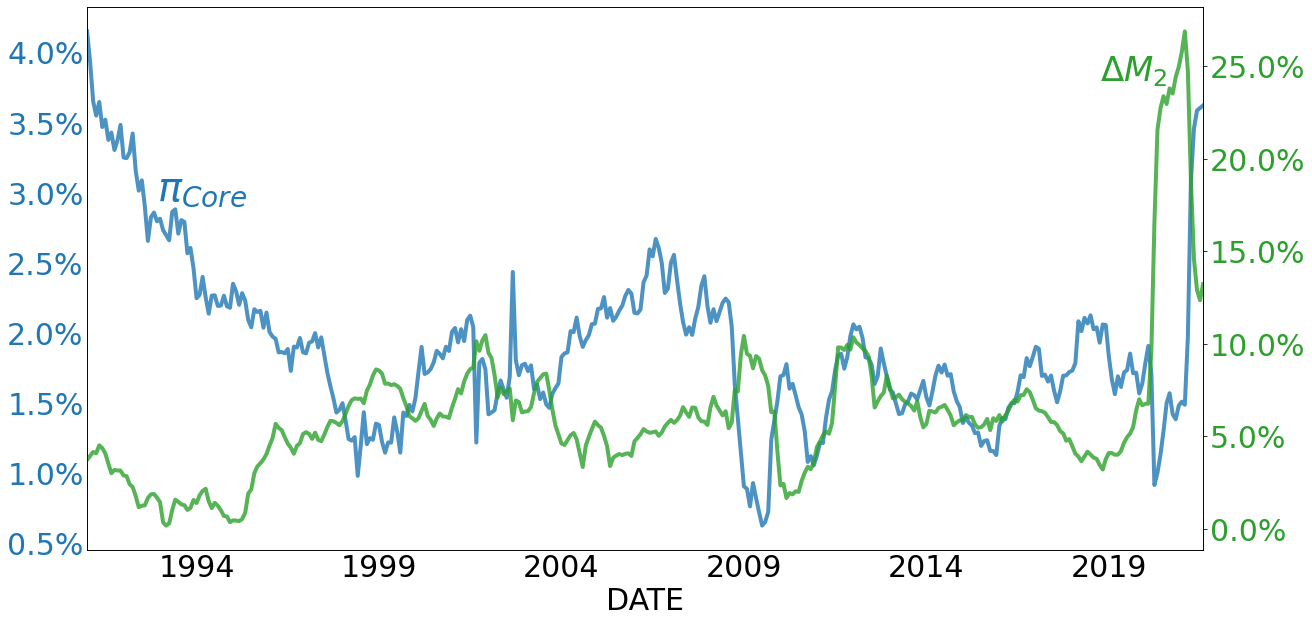

In [575]:
plot_keys = ["$\pi_{Core}$",
            "M2 Annual % Change"]
plot_df = df[plot_keys]
fig,ax = plt.subplots(figsize=(20,10))
plot_df[plot_keys[0]].dropna().plot.line(linewidth = 4, 
                           legend = False,
                          ax = ax,
                          alpha = .8)
ax2 =ax.twinx()
plot_df[plot_keys[1]].dropna().plot.line(linewidth = 4, 
                           legend = False,
                          ax = ax2,
                          alpha = .8, color = "C2")

ax.set_yticklabels([str(val) + "%" for val in ax.get_yticks()], color = "C0")
ax2.set_yticklabels([str(val) + "%" for val in ax2.get_yticks()], color = "C2")
ax.text(585, 3.8, "$\Delta M_2$", color = "C2", fontsize= 34)
ax.text(275, 2.95, plot_keys[0], color = "C0", fontsize = 40)

plt.xticks(rotation=90, fontsize =26)
ax.tick_params('both', length=0, which='both')
# ax.set_ylabel(plot_keys[0],fontsize = 40, color = "C0")
# ax2.set_ylabel("$\Delta$",fontsize = 40, color = "C2")

<ipython-input-573-7755ba5998cc>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val)) + "%" for val in ax.get_yticks()])


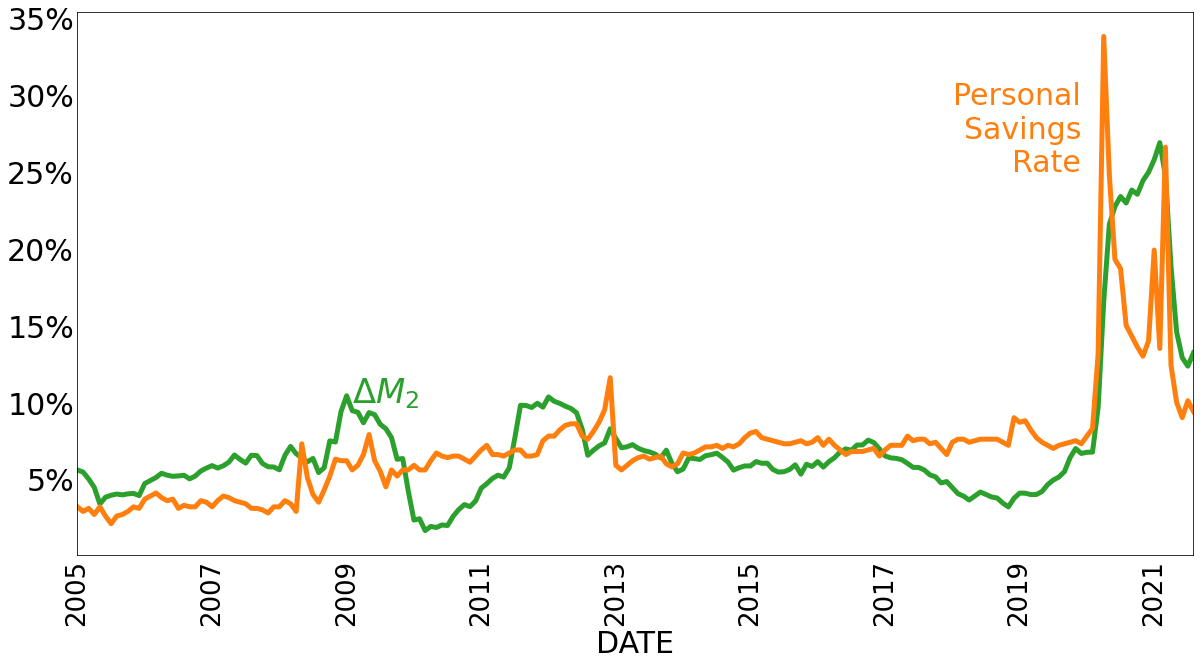

In [573]:
fig,ax = plt.subplots(figsize=(20,10))
plot_keys = ["M2 Annual % Change", 
            "Personal Savings Rate"]
plot_df = df[plot_keys].loc["2005":]
plot_df.plot.line(linewidth = 5, 
                  legend = False, 
                 ax = ax, color = ["C2","C1"])
ax.text(475, 10,"$\Delta M_2$", color = "C2", ha = "center", fontsize = 34)
ax.text(599, 25, plot_keys[1].replace(" ","\n"), color = "C1", ha = "right")
plt.xticks(rotation=90, fontsize =26)
ax.tick_params('both', length=0, which='both')
# ax.set_ylim(0)
ax.set_yticklabels([str(int(val)) + "%" for val in ax.get_yticks()])

plot_df.to_csv("M2RateData.csv")